In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%xmode plain

Exception reporting mode: Plain


In [2]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import ctypes
import mpl_toolkits.mplot3d as a3
# import matplotlib.colors as colors

In [3]:
import IPython

In [4]:
import plisdku.plot
import particlegrid3
import cube
from jiggler import Jiggler


# Jiggle the particles

In [5]:
def randin(bounds):
    return np.random.rand(3)*(bounds[1]-bounds[0]) + bounds[0]

def random_cube(center_bounds, r_bounds):
    center = randin(center_bounds)
    r = randin(r_bounds)
    c = cube.Cube(center, *r)
    
    c.rotate_x(np.random.rand() * 2*np.pi)
    c.rotate_y(np.random.rand() * 2*np.pi)
    c.rotate_z(np.random.rand() * 2*np.pi)
    
    return c

c = random_cube((0.0, 10.0), (0.5, 1.0))

In [6]:
grid_size = (10.0, 10.0, 10.0)
max_radius = 0.7
jiggler = Jiggler(grid_size, 1.0, max_radius, accel=1.0001, decel=0.9999)

genfun = lambda: random_cube((0.0, 10.0), (max_radius/4, max_radius/2))
for n_rect in range(1000):
    jiggler.particle_grid.try_add_particle(genfun)

zs = np.array([p.centroid[2] for p in jiggler.particle_grid.particles])
izs = np.argsort(np.argsort(zs)) # !!! lolol

color_points = izs / float(len(izs)-1)
colors = plt.cm.hsv(color_points)

In [7]:
cube.write_binary("thing.stl", jiggler.particle_grid.particles, 1.0)

In [8]:
forces = np.array([np.linalg.norm(jiggler.particle_grid.force(p)) for p in jiggler.particle_grid.particles])

(-1, 11)

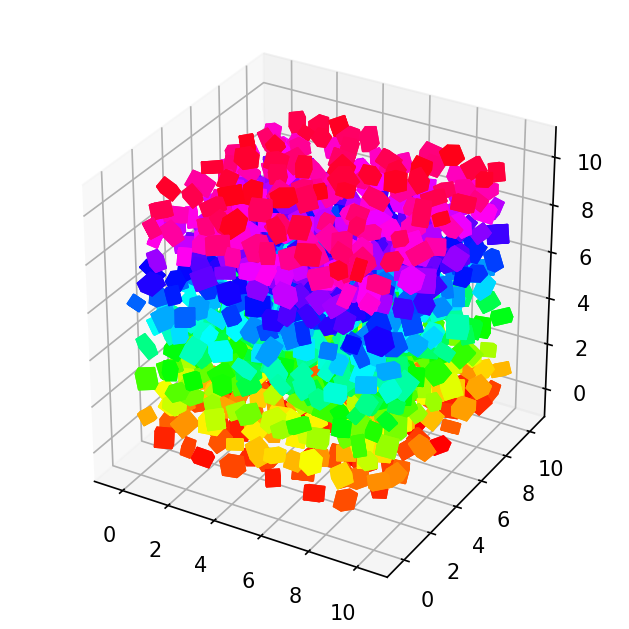

In [9]:
ax = a3.Axes3D(plt.figure(dpi=150))
jiggler.particle_grid.plt_polygons_3d(colors=colors)

# for p in jiggler.particle_grid.particles:
#     f = jiggler.particle_grid.force(p)/100
#     ax.quiver3D(p.centroid[0], p.centroid[1], p.centroid[2], f[0], f[1], f[2])

plt.axis('image')
ax.set_xlim([-1,11])
ax.set_ylim([-1,11])
ax.set_zlim([-1,11])

In [14]:
exp_dir = "without_force_1k"
if not os.path.isdir(exp_dir):
    os.mkdir(exp_dir)

In [15]:
particle_volume = np.sum([8*np.prod(p.radii) for p in jiggler.particle_grid.particles])
jiggler_volume = np.prod(jiggler.particle_grid.size_xyz)
print("Particle volume", particle_volume, "in space volume", jiggler_volume)

Particle volume 136.5397003206234 in space volume 1000.0


In [16]:
def shake_n_bake(num_iters, particles_per_itr, num_particles, exp_dir):
    grid_size = (10.0, 10.0, 10.0)
    max_radius = 0.7
    jiggler = Jiggler(grid_size, 1.0, max_radius, accel=1.0001, decel=0.9999)

    genfun = lambda: random_cube((0.0, 10.0), (max_radius/4, max_radius/2))
    for n_rect in range(num_particles):
        jiggler.particle_grid.try_add_particle(genfun)
    
    strains = []
    t_elapsed = []
    t0 = time.time()
    
    for _itr in range(num_iters):
        jiggler.try_perturb_strain()
        for _ in range(particles_per_itr):
            jiggler.try_move()
            jiggler.try_rotation()
        print(f"Iteration {_itr}")
        
        strains.append(jiggler.particle_grid.strain)
        t_elapsed.append(time.time() - t0)
    
    if not os.path.isdir(exp_dir):
        os.mkdir(exp_dir)
    cube.write_binary(os.path.join(exp_dir, f"ppi_{particles_per_itr:05g}.stl"), jiggler.particle_grid.particles, jiggler.particle_grid.strain)
    
    return strains, t_elapsed

640 particles per iteration


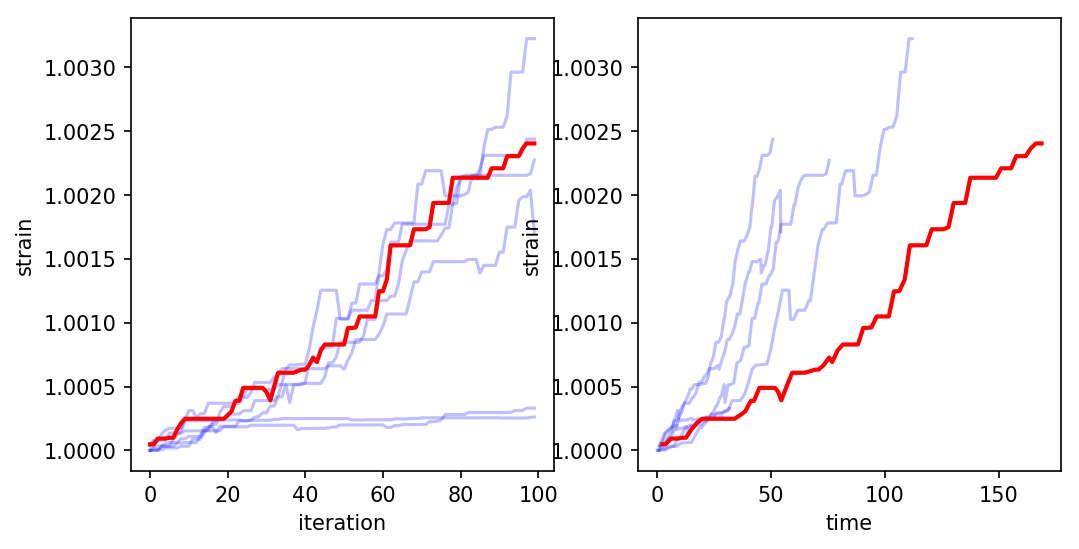

Iteration 0


KeyboardInterrupt: 

In [17]:
particles_per_itr_list = np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240])

num_iters = 100

t_list = []
strains_list = []

for particles_per_itr in particles_per_itr_list:
    strains, t = shake_n_bake(num_iters, particles_per_itr, 1000, "test")
    
    strains_list.append(strains)
    t_list.append(t)
    
    IPython.display.clear_output()
    print(f"{particles_per_itr} particles per iteration")
    plt.figure(dpi=150, figsize=(8,4))
    plt.subplot(121)
    for tt,ss in zip(t_list, strains_list):
        plt.plot(ss, 'b-', alpha=0.25)
    plt.plot(strains, 'r-', linewidth=2)
    plt.xlabel('iteration')
    plt.ylabel('strain')
    plt.subplot(122)
    for tt,ss in zip(t_list, strains_list):
        plt.plot(tt, ss, 'b-', alpha=0.25)
    plt.plot(t, strains, 'r-', linewidth=2)
    plt.xlabel('time')
    plt.ylabel('strain')
    plt.show()
    

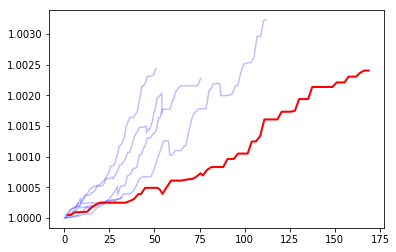

In [18]:
for tt,ss in zip(t_list, strains_list):
    plt.plot(tt, ss, 'b-', alpha=0.25)
plt.plot(t, strains, 'r-', linewidth=2)

In [19]:
particles_per_itr_list

array([   10,    20,    40,    80,   160,   320,   640,  1280,  2560,
        5120, 10240])

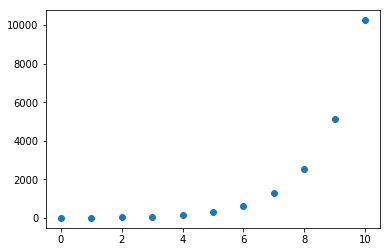

In [20]:
plt.plot(particles_per_itr_list, 'o')

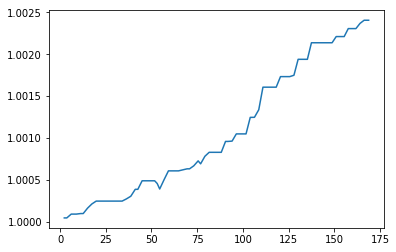

In [21]:
plt.plot(t, strains)

In [23]:
num_particles = len(jiggler.particle_grid.particles)

strains = []
strain_itrs = []
timestamps = []

idx_fig = 0

t0 = time.time()

for _itr in range(10000000):
    
    if _itr%5 == 0:
        IPython.display.clear_output(wait=True)
        
        ax = a3.Axes3D(plt.figure(dpi=150))
        jiggler.particle_grid.plt_polygons_3d(colors=colors)
        plt.axis('image')
        ax.set_xlim([-1,11])
        ax.set_ylim([-1,11])
        ax.set_zlim([-1,11])
        plt.savefig(os.path.join(exp_dir, f"frame_{idx_fig:07g}.png"), bbox_inches='tight')
        plt.close()
        idx_fig += 1
        
    
    if _itr%10 == 0:
        strains.append(jiggler.particle_grid.strain)
        strain_itrs.append(_itr)
        timestamps.append(time.time() - t0)
        
        scaled_particle_volume = np.array(strains)**3 * particle_volume
        volume_fraction = scaled_particle_volume / jiggler_volume
        plt.figure()
        plt.plot(strain_itrs, volume_fraction, "-")
        plt.title('Volume fraction')
        plt.savefig(os.path.join(exp_dir, f"volume.png"), bbox_inches='tight')
        plt.close()
        
        np.savetxt(os.path.join(exp_dir, "volume.txt"), np.column_stack((strain_itrs, timestamps, volume_fraction)))
        
        cube.write_binary(os.path.join(exp_dir, f"cubes_{_itr:07g}.stl"), jiggler.particle_grid.particles, jiggler.particle_grid.strain)
        
    jiggler.try_perturb_strain()
    for _ in range(num_particles):
        jiggler.try_move()
        jiggler.try_rotation()
    
    print(f"Iteration {_itr}")


Iteration 50
Iteration 51
Iteration 52
Iteration 53


KeyboardInterrupt: 